# CLIMADA & OpenStreetMap

CLIMADA provides some ways to make use of the entire [OpenStreetMap data world](https://www.openstreetmap.org/) and to use those data within the risk modelling chain of CLIMADA as exposures.

This tutorial will walk you through the two major parts in detail:
* Getting the data
* Converting it into a useful `Exposures()` format or refining existing coarse-scale `LitPop()` exposures for impact calculations.

The `openstreetmap` module hence contains two sub-modules:

* `osm_dataloader.py`, which handles the loading of raw map data and the extraction of specific info into useful geodataframe formats 
    
* `osm_exposuremaker.py`, which deals with the step of converting map info into a `climada.exposures` instance as well as some links to the `LitPop` exposure.

## Outline
* [**Part 1:**](#Part1) **Downloading OSM Data**
    * [**1.1**](#Part1.1) From extracting data in country-wise data-dumps obtained from Geofabrik
    * [**1.2**](#Part1.2) From exracting data in custom-cut data dumps obtained from the planet file
    * [**1.3**](#Part1.3) From direct API-queries over the overpass-api.
* [**Part 2:**](#Part2) **Converting OSM Data to CLIMADA Exposures**
    * 2.1 Setting up a new Exposures instance using OSM data
    * 2.2 Using OSM data as stencils to downscale LitPop exposure instances

<a id='Part1'></a> 
## Part 1: Downloading OSM data

 **Which methods exist for getting data and which one is right for my query?**
 
 
  This module (`osm_dataloader.py`) provides 3 "pathways" to obtain OSM data in useable geodataframe format:
  
  Two pathways first download _all_ map raw data witin a certain geographic area that is on OSM, in the OSM-specific data format (osm.pbf). Then, an SQL query extracts only the info that is wanted and loads it into memory. They only differ in terms of the size of the raw data: Either countries are downloaded (from a daily-updated provider, Geofabrik.de), or the entire planet file is downloaded once, and sub-files with raw data for any desired custom-made region are cut out form this planet file. The query/extraction process afterwards is the same.
  
  The other pathway directly and selectively loads the desired info from the overpass-turbo API, without downloading the complete raw data dumps beforehand. This is however heavily constrained in terms of download quota and not very stable.
  
 They pathways are illustrated below.
 The described functionalities are contained in 3 classes:
  * `OSMRaw` - methods to download raw map datafiles from servers, at country or planet-scale.
  * `OSMFileQuery` - methods to extract specific info from the raw files and assemble them into gdfs.
  * `OSMApiQuery` - methods to directly load specific map info & assemble into gdfs, via the overpass-turbo API.

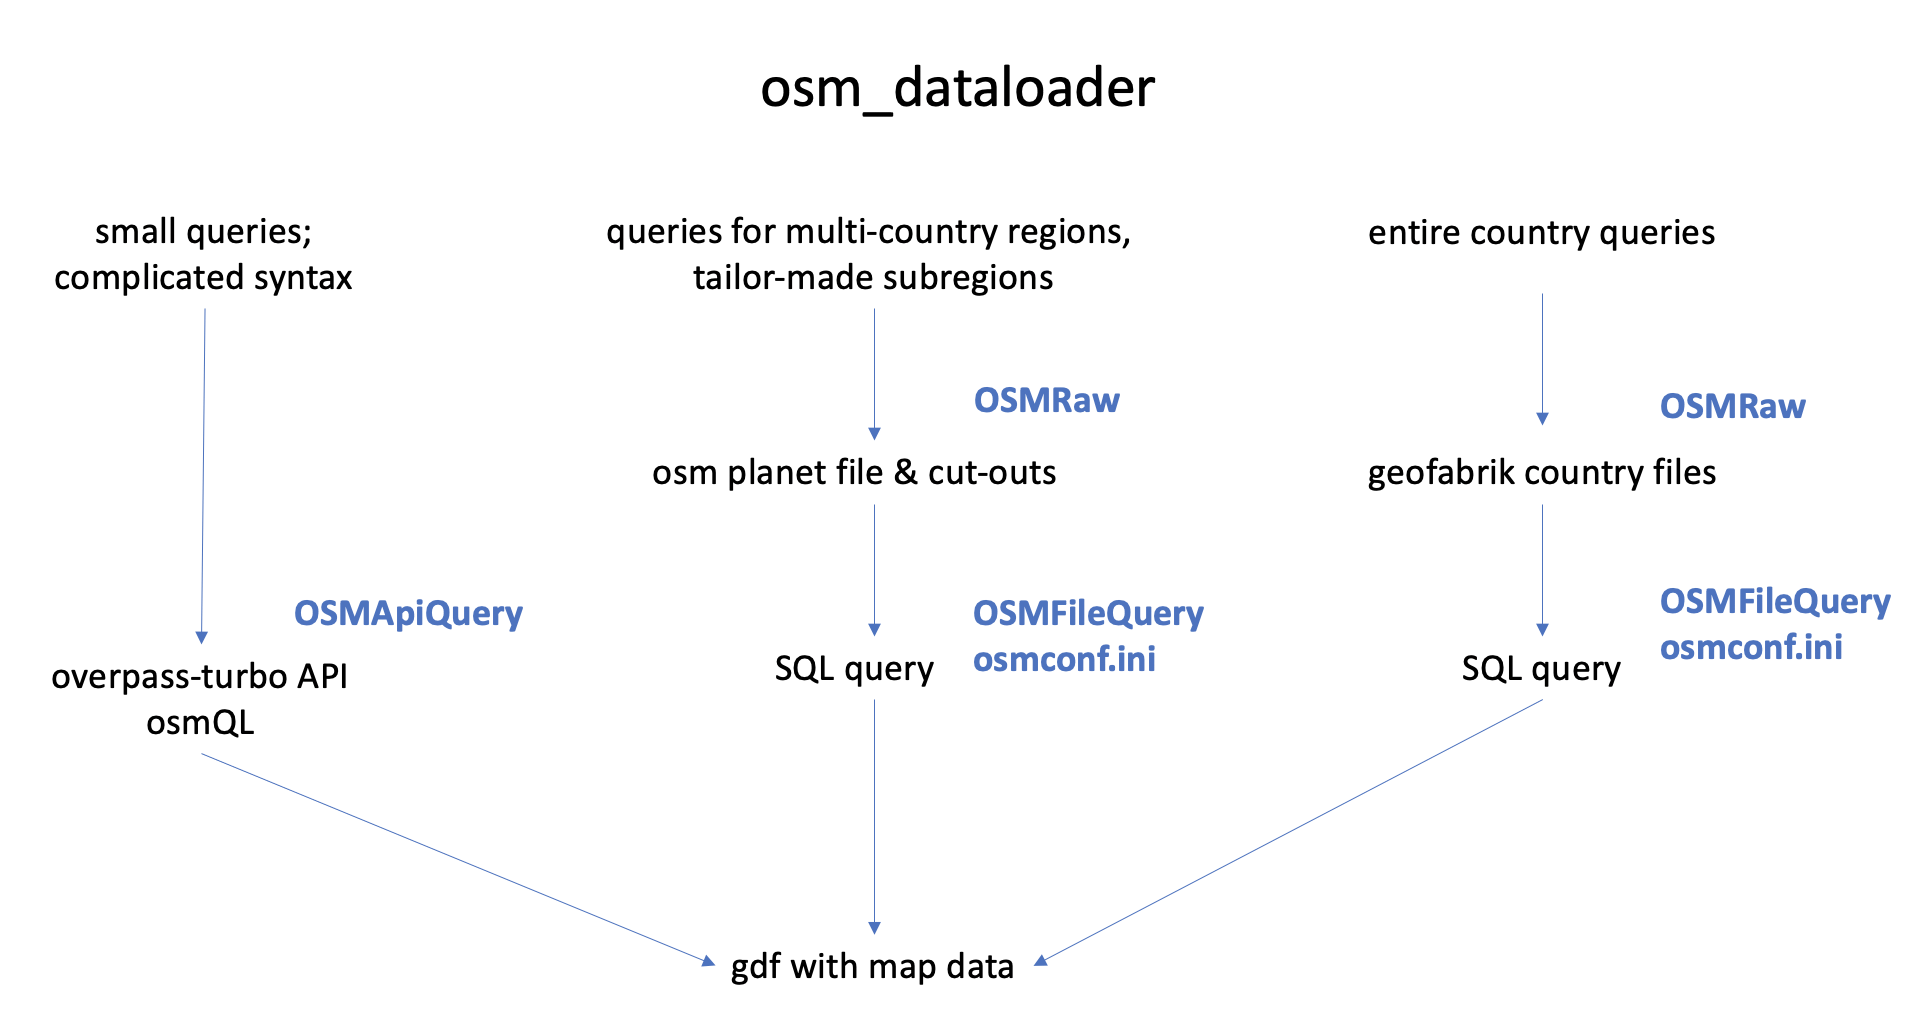

**A few words on the OSM data world, OSM overpass-turbo, Overpass QL & OSM data structures (nodes, ways, relations)**

**OSM tags, key-value pairs, and quick overview on "what's out there"** Check out https://taginfo.openstreetmap.org/ for finding the key-value pairs ("tags") you're looking for. You will need to know this for specifying your query (at least in the API-pathway).
Check out https://overpass-turbo.eu/ for a fast visual overview on results that your query will yield.

**The OSM API (overpass)**: The OSM API has constraints on how much can be downloaded at once (reached quite fast, especially around mid-day / early afternoon..). This is why providers (such as [Geofabrik](https://www.geofabrik.de/)) exist that generate data daily data dumps of all the OSM data that exists. For the API downloading strategy, wait-times are implemented in the querying, but re-consider your strategy if you run into a time-out error. Overpass Query language, which is needed to query directly from the OSM API can be a bit cryptic. The majority of what you will need is transformed in the `OSMApiQuery` class automatically.
For more, check out the detailed read-the-docs: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL 

**OSM data structures:** Elements are the basic components of OpenStreetMap's conceptual data model of the physical world. Elements are of three types:

* nodes (defining points in space),
* ways (defining linear features and area boundaries), and
* relations (which are sometimes used to explain how other elements work together).

Check out https://wiki.openstreetmap.org/wiki/Elements for more info.

<a id='Part1.1'></a> 
### Part 1.1:  Extracting info from country-wise raw data dumps

In this example, we download the data dump for a country (Honduras) from Geofabrik. While Geofabrik provides two formats: shapefiles (.shp) and protocol binary format (.pbf), the latter has much smaller file sizes. In the second step, specific info can be extracted from the raw files, using the `OSMFileQuery`. The query functions work for .pbf format only (since shapefiles can be directly read into gdfs and filtered afterwards).

In [12]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from pathlib import Path

from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMApiQuery, OSMFileQuery
from climada import CONFIG

DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()

In [2]:
# download osm.pbf file for Honduras from geofabrik (checks if file honduras-latest.osm.pbf already exists)
OSMRaw().get_data_geofabrik('HND', file_format='pbf', save_path=DATA_DIR)

2022-01-27 12:25:07,583 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - Downloading file as /Users/evelynm/climada/data/openstreetmap/honduras-latest.osm.pbf


In [3]:
# Initiate a OSMFileQuery instance with path to the downloaded file
HNDFileQuery = OSMFileQuery(Path(DATA_DIR,'honduras-latest.osm.pbf'))

**Extracting critical infrastructures with pre-written filequery wrappers**

For critical infrastructures, a set of wrappers exist that perform the query under the hood. They collect a range of applicable tags from openstreetmap that go under the respective infrastructure type and load all of them into one dataframe. The reported columns and tags that are queried can be inspected (and modified) in the dictionary `DICT_CIS_OSM`:

In [4]:
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

In [5]:
# check available critical infrastructure types:
DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food'])

In [5]:
# lets extract all roads from the Honduras file, via the CI-wrapper
gdf_roads = HNDFileQuery.retrieve_cis('road')

2022-01-27 12:25:36,583 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 0it [00:00, ?it/s]

2022-01-27 12:25:37,528 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|███████████████████| 4/4 [00:09<00:00,  2.46s/it]

2022-01-27 12:25:57,830 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract lines: 100%|███████████████| 108278/108278 [00:13<00:00, 8035.13it/s]


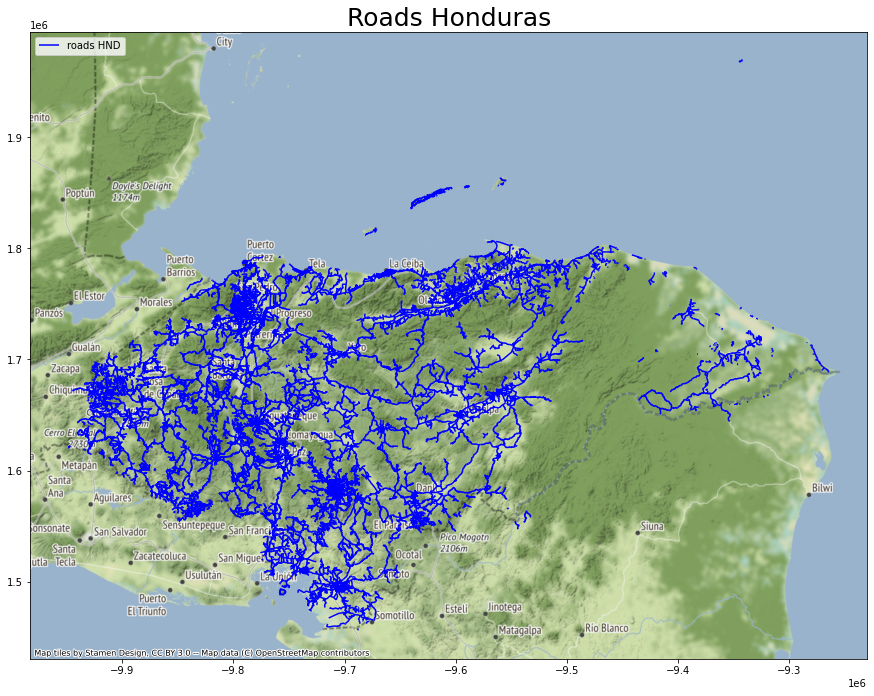

In [7]:
# plot results
ax = gdf_roads.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='roads HND')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Roads Honduras', fontsize=25)
ctx.add_basemap(ax)
plt.show()

**Extracting any other info from the data dump**

Any other tags that are available on openstreetmap can also be queried with the `retrieve()` method.
Two variables have to be specified: `osm_keys`, a list with all the columns to report in the gdf, and `osm_query`, a string of key-value constraints to apply during the search.

**The osmconf.ini file - need to know:**
The retrieve function needs a configuration file, where it is specified for which geometry types it should look, given which key or key-value pair. The `osmconf.ini` file is located under `~\exposures\openstreetmap\osmconf.ini`. All more common keys or key-value pairs have been included in this file, but it is worth checking that your query doesn't contain any unknown ones. Else, enter it in the respective paragraph:

For example under `[points]`, in the `attributes=` section, all the keys / key-value pairs are reported that should be extracted, if they have a point geometry. You can see that the key `building` exists both in the points as well as in the multipolygons section, meaning that the query will extract all instances of `building` in a raw file that are of type point or multipolygon.

In [6]:
# Forests in HND.
osm_keys = ['landuse']
osm_query = "landuse='forest'"
gdf_forest = HNDFileQuery.retrieve('multipolygons', osm_keys, osm_query)

2022-01-27 12:26:21,442 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|██████████████| 687/687 [00:04<00:00, 138.75it/s]


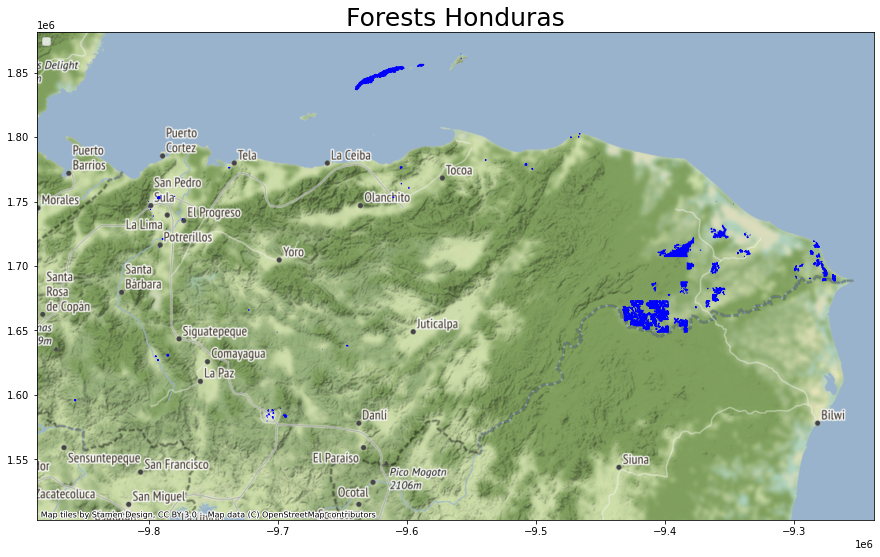

In [9]:
# Plot results
ax = gdf_forest.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='forests HND')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Forests Honduras', fontsize=25)
ctx.add_basemap(ax)
plt.show()

<a id='Part1.2'></a> 
### Part 1.2 Extracting info from custom-cut raw data dumps 

Instead of retrieving all the applicable data within a country raw data file, we can cut out any desired shape or bounding box from the entire planet file (has to be downloaded first once, ca. 60 GB) and then perform an extraction on this sub-file.

To cut out shapes from the planet.osm.pbf file, we use command line tool `osmosis` under the hood. The desired shapes have to be provided as `.poly` files (See e.g. https://github.com/ElcoK/osm_clipper for admin3 to admin1 level shape conversions), whereas bounding boxes can be passed as lists ([xmin, ymin, xmax, ymax])

Osmosis likely needs to be installed first (works for Windows, Linux and Apple -https://wiki.openstreetmap.org/wiki/Osmosis/Installation). You may also need to install Java.


**Note 1** Downloads planet file at first call.

**Note 2** Takes quite a while to cut out certain parts (up to an hour..)

In [25]:
# Define a bbox around roughly Honduras, San Salvador & Nicaragua
bbox_customreg = [-90.043806, 10.939216, -83.116254, 15.956278]

# Specify filepaths for planet file and for new file
path_planet = Path(DATA_DIR, 'planet-latest.osm.pbf')
path_extract = Path(DATA_DIR, 'HND_NIC_SLV.osm.pbf')

OSMRaw().get_data_planetextract(shape=bbox_customreg,
                                path_extract=path_extract,
                                path_planet=path_planet)

2021-10-01 12:19:13,175 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - Extracted file already exists!


Now we can repeat a similar query (e.g. road data) for our newly cut-out data region.

In [20]:
HndNicSlvFileQuery = OSMFileQuery(path_extract)
gdf_roads_HndNicSlv = HndNicSlvFileQuery.retrieve_cis('road')

extract lines: 100%|███████████████████████████████████████████████████████████████████████████| 18485/18485 [00:09<00:00, 2017.80it/s]


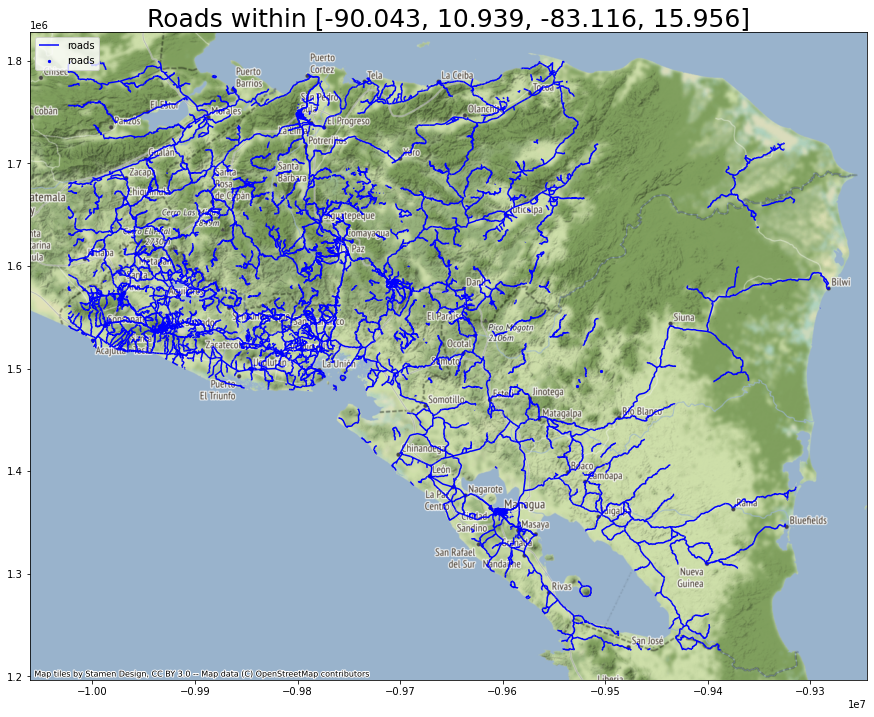

In [23]:
# plot results
ax = gdf_roads_HndNicSlv.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='roads')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Roads within [-90.043, 10.939, -83.116, 15.956]', fontsize=25)
ctx.add_basemap(ax)
plt.show()

<a id='Part1.3'></a> 
### Part 1.3: Directly loading data from the overpass-API

At the moment, the `OSMApiQuery` class accepts both an _area_ and a _query condition_ as inputs.

Area can be a bounding box (xmin, ymin, xmax, ymax) or a polygon.
The query conditions must be a string in the format `'["key"]'` or `'["key"="value"]'`, etc. For more query syntaxes, have a look at the [OverpassQL page](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL).

####  Example: Buildings & Churches in the city of Zurich

In [13]:
# reload required modules
import shapely
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMApiQuery
from climada import CONFIG

DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()

In [14]:
# Two area-formats that are accepted: a bounding box tuple or list (xmin, ymin, xmax, ymax) and polygons
area_bbox = (8.5327506, 47.368260, 8.5486078, 47.376877)
area_poly = shapely.geometry.Polygon([(8.5327506, 47.368260), (8.5486078, 47.376877), (8.5486078, 47.39)])

# Two examples for query conditions:
condition_church = '["amenity"="place_of_worship"]'
condition_builidng = '["building"]'

# Initialize OSMApiQuery instances
zrh_churchquery_bbox = OSMApiQuery(area_bbox, condition_church)
zrh_buildingquery_poly = OSMApiQuery(area_poly, condition_builidng)

After instantiating the queries with an area and a query condition, the data can now be downloaded from the overpass-API. Depending on the time of the day and the size of the query, this can lead to overloads.

The following request should be small enough that it always works:

In [15]:
gdf_zrh_churches = zrh_churchquery_bbox.get_data_overpass()

/Users/evelynm/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:726: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf_nodes = self._assemble_from_nodes(result, nodes_avail)
/Users/evelynm/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:680: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array([data_id,data_geom,data_tags]).T,


In [ ]:
gdf_zrh_buildings = zrh_buildingquery_poly.get_data_overpass()

Let's have look at our downloaded data. The downloaded data is assembled into a geodataframe with an `osm_id` column and a `tags` columns. The latter reports all the tags associated with the respective result.

In [31]:
gdf_zrh_churches

,osm_id,geometry,tags
0,24701951,"POLYGON ((8.54050 47.37097, 8.54058 47.37098, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
1,33854803,"POLYGON ((8.54552 47.37404, 8.54552 47.37404, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
2,36916418,"POLYGON ((8.54413 47.37017, 8.54405 47.37021, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
3,40478435,"POLYGON ((8.54656 47.37475, 8.54628 47.37464, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
4,80338523,"POLYGON ((8.53520 47.37333, 8.53494 47.37345, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
5,80340830,"POLYGON ((8.53661 47.37279, 8.53676 47.37289, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
6,89469961,"POLYGON ((8.53964 47.37177, 8.53929 47.37166, ...","{'addr:housenumber': '2', 'addr:street': 'Münz..."
7,89967877,"POLYGON ((8.54120 47.36959, 8.54120 47.36962, ...","{'addr:city': 'Zürich', 'addr:country': 'CH', ..."
8,112795856,"POLYGON ((8.54317 47.36953, 8.54314 47.36952, ...","{'addr:housenumber': '29', 'addr:street': 'Lim..."
9,292437788,"POLYGON ((8.54482 47.37039, 8.54477 47.37037, ...","{'amenity': 'place_of_worship', 'building': 'y..."


<AxesSubplot:>

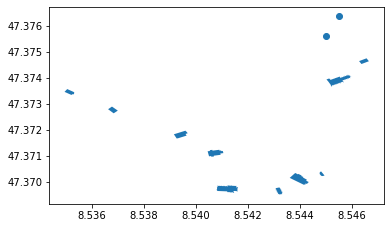

In [32]:
gdf_zrh_churches.plot();

In [ ]:
gdf_zrh_buildings

<AxesSubplot:>

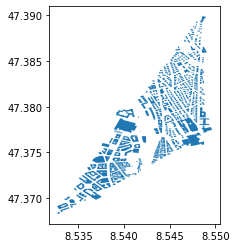

In [34]:
gdf_zrh_buildings.plot();

<a id='Part2'></a> 
## Part 2: CLIMADA Exposures from OSM data

As from this stage on, the user has geodataframe(s) at their hand with point, polygon and / or line geometries, the tutorial in [climada_python/doc/tutorial/entity_exposures_lines_polygons](https://github.com/CLIMADA-project/climada_python/blob/feature/lines_polygons_exp/doc/tutorial/climada_entity_Exposures_polygons_lines.ipynb) gives detailed info on how to generally handle those types within CLIMADA exposures.

For completeness, a short demo will still be given here using OSM data.

**Disclaimer** As of the current state (Oct. 2021), the lines & polygons functionalities work only on climada_python branch `feature/lines_polygons_exp`. Hence you need to be on this branch to execute the following cells.

<a id='Part2.1'></a> 
### Part 2.1: Setting up a high-res CLIMADA exposure from scratch with point, line & polygon data from OSM



The general steps are the following to create exposures from line or polygon data from OSM: 

1) Lines / Polygons to points: Specify a metre distance into which lines are split, or a m2 area into which polygons are split, to get an interpolated gdf. 

2) Valuation: Indicate a value per meter or m2, or use LitPop asset values to re-distribute proportionally.

3) Point-Exposure is ready to use

4) Re-aggregation to initial shapes after impact calculation.

**Example 1: CLIMADA exposure from OSM polygon-data (buildings)**

We will take the previously loaded gdf of buildings in Zurich (`gdf_zrh_buildings`) as input.
Assuming that 1 m2 of building area has a value of (arbitrary) 5400 $ (`m2_value`), we can set up a CLIMADA point exposure for one point per 50m2 (`m2_per_point`) using the respective `Exposures` method `set_from_polygons` :

**Note** The following cells rely on functions from a climada-python branch that is work-in-progress.
If you want to execute them, please switch to branch `feature/lines_polygons_exp` on climada_python.

In [35]:
"""
from climada.entity.exposures import Exposures

# gdf needs to be in a projected CRS (lat/lon) to allow for constructing metre-based grids
gdf_zrh_buildings = gdf_zrh_buildings.set_crs(epsg=4326)

exp_buildings_zrh = Exposures()
# one point per 50m2, 5400$/m2 assumed value, all points same value ('cnst'):
exp_buildings_zrh.set_from_polygons(gdf_zrh_buildings, m2_per_point=50, m2_value=5400, disagg_values='cnst')
"""

2021-10-01 14:22:07,492 - climada.util.coordinates - INFO - Empty geometries encountered. Skipping those.
2021-10-01 14:22:07,510 - climada.util.coordinates - INFO - Got an empty geometry. Returning None.
2021-10-01 14:22:07,584 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,595 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,598 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,605 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,610 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assignin

2021-10-01 14:22:07,984 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,986 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,989 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,992 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,994 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:07,997 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021

2021-10-01 14:22:08,179 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:08,182 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:08,186 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:08,187 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:08,189 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:08,191 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021

<AxesSubplot:>

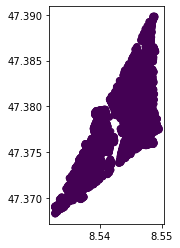

In [36]:
"""
# Looking at the newly constructed exposure
exp_buildings_zrh.gdf.plot('value');
"""

Instead of just assuming an arbitrary m2-value for the asset valuation, we can also use an estimate from `LitPop`, by specifying the respective kwargs in the `set_from_polygons` method:

In [37]:
"""
from climada.entity.exposures import Exposures

# gdf needs to be in a projected CRS (lat/lon) to allow for constructing metre-based grids
gdf_zrh_buildings = gdf_zrh_buildings.set_crs(epsg=4326)

exp_buildings_zrh = Exposures()
# one point per 50m2, value per point taken from LitPop estimate ('litpop'), 
# for an area lying in Switzerland (`CHE`):
exp_buildings_zrh.set_from_polygons(gdf_zrh_buildings, m2_per_point=50, disagg_values='litpop', countries='CHE')
"""

2021-10-01 14:22:19,149 - climada.util.coordinates - INFO - Empty geometries encountered. Skipping those.
2021-10-01 14:22:19,168 - climada.util.coordinates - INFO - Got an empty geometry. Returning None.
2021-10-01 14:22:19,242 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,252 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,255 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,262 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,266 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assignin

2021-10-01 14:22:19,642 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,643 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,646 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,649 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,651 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,653 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021

2021-10-01 14:22:19,835 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,837 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,841 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,843 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,845 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021-10-01 14:22:19,847 - climada.util.coordinates - INFO - Chosen resolution too coarse for polygon. 
                    Assigning one representative point instead
2021

<AxesSubplot:>

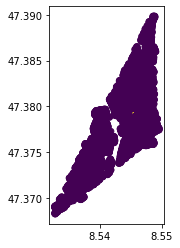

In [38]:
"""# Looking at the newly constructed exposure
exp_buildings_zrh.gdf.plot('value');
"""

<a id='Part2.2'></a> 
### Part 2.2: Refining LitPop - Cutting out low value areas using OSM info

The idea behind this "reverse approach" to the one demonstrated before is to use OpenStreetMap info as a "stencil" for downscaling the coarser LitPop asset values (roughly 1x1km2), by defining low-value areas, and allocating all LitPop values to the _remaining_ area.

There are in turn several methods on how the allocation is done:
* equally spreading out the gridcell value on all the "valid" areas
* re-locating LitPop values based on nearest-neighbour centroids

**Example for cutting out "low-value" features from LitPop cells**

"Low value features" in terms of asset values, i.e. natural areas, etc. can be found on OSM under the following keys and key-value pairs (not extensive list):
* 'natural',
* 'water', 
* 'waterway', 
* 'landuse=forest', 
* 'landuse=farmland',
* 'landuse=grass', 
* 'wetland'

In [39]:
# Load required packages:


In [ ]:
# One command does it all (getting LitPop Exp, re-assigning values, converting back into exposure format)


**Example for assigning high-value features to LitPop cells**